In [1]:
import os
from google.cloud import bigquery as bq
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

service_account_path = '/home/yusuf/DataScience/dream_games/ybektas20.json'
client = bq.Client.from_service_account_json(service_account_path)
shapes_query = """
WITH row_counts AS (
  SELECT 'q1_table_install' AS table_name, (SELECT COUNT(*) FROM `casedreamgames.case_db.q1_table_install`) AS row_count UNION ALL
  SELECT 'q1_table_level_end' AS table_name, (SELECT COUNT(*) FROM `casedreamgames.case_db.q1_table_level_end`) AS row_count UNION ALL
  SELECT 'q1_table_session' AS table_name, (SELECT COUNT(*) FROM `casedreamgames.case_db.q1_table_session`) AS row_count UNION ALL
  SELECT 'q1_table_revenue' AS table_name, (SELECT COUNT(*) FROM `casedreamgames.case_db.q1_table_revenue`) AS row_count UNION ALL
  SELECT 'q1_table_cost' AS table_name, (SELECT COUNT(*) FROM `casedreamgames.case_db.q1_table_cost`) AS row_count
),
column_counts AS (
  SELECT table_name, COUNT(*) AS column_count
  FROM `casedreamgames.case_db.INFORMATION_SCHEMA.COLUMNS`
  WHERE table_name IN ('q1_table_install', 'q1_table_level_end', 'q1_table_session', 'q1_table_revenue', 'q1_table_cost')
  GROUP BY table_name
)
SELECT r.table_name, r.row_count, c.column_count
FROM row_counts r
JOIN column_counts c ON r.table_name = c.table_name;

"""

shapes = client.query(shapes_query).result().to_dataframe()
shapes.set_index('table_name', inplace=True)
shapes

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,row_count,column_count
table_name,,
q1_table_install,217415,5
q1_table_session,297358858,6
q1_table_revenue,64952,5
q1_table_cost,1357,5
q1_table_level_end,72044374,8


In [24]:
from q1 import *

dau_by_platform = get_dau_by_platform()
dau_by_platform


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,platform,dau
0,2021-05-17,None,1
1,2021-05-22,None,2
2,2021-05-28,None,1
3,2021-06-04,None,1
4,2021-06-06,None,1
...,...,...,...
95,2021-06-10,ios,36278
96,2021-06-11,ios,36080
97,2021-06-12,ios,35937
98,2021-06-13,ios,35954


In [27]:
dau_by_platform.isna().sum()

date        0
platform    7
dau         0
dtype: int64

In [25]:
dau_by_platform.platform.value_counts()

platform
android    46
ios        46
andrgid     1
Name: count, dtype: int64

In [2]:
dau_query = """
-- Query 1: Daily Active Users (DAU)
SELECT
  DATE(event_time) AS date,
  COUNT(DISTINCT user_id) AS dau
FROM `casedreamgames.case_db.q1_table_session`
GROUP BY date
ORDER BY date;

"""

dau = client.query(dau_query).result().to_dataframe()
dau.set_index('date', inplace=True)
dau

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,dau
date,
2021-04-30,217
2021-05-01,9877
2021-05-02,14555
2021-05-03,15823
2021-05-04,18403
2021-05-05,21663
2021-05-06,22166
2021-05-07,24929
2021-05-08,28632


<Axes: title={'center': 'DAU'}, xlabel='date'>

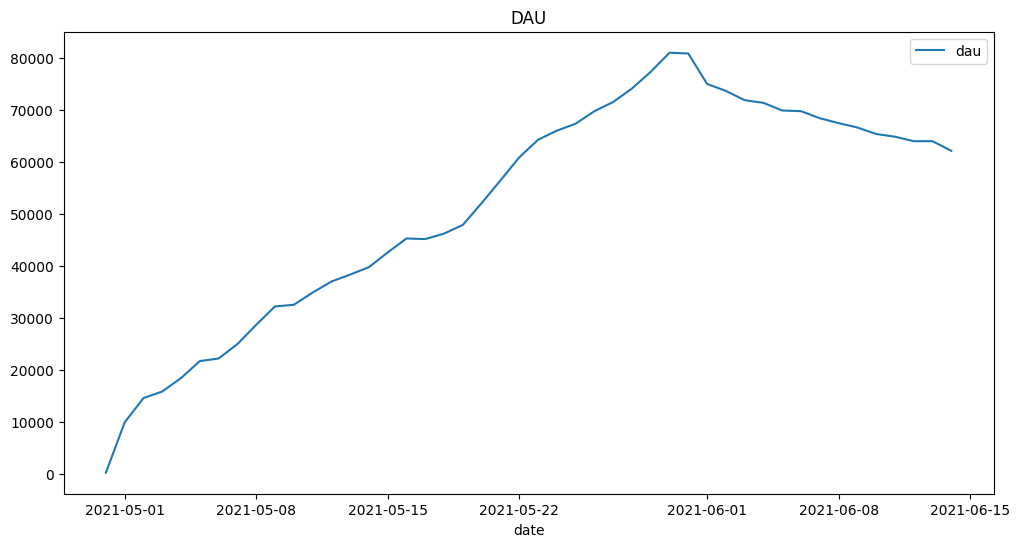

In [4]:
dau.plot(title='DAU', figsize=(12, 6))

In [5]:
arpu_query = """
SELECT
  DATE(i.event_time) AS date,
  SUM(CAST(r.revenue AS FLOAT64)) / COUNT(DISTINCT i.user_id) AS arpu
FROM `casedreamgames.case_db.q1_table_install` i
JOIN `casedreamgames.case_db.q1_table_revenue` r
  ON i.user_id = r.user_id
GROUP BY DATE(i.event_time)
ORDER BY date;

"""
arpu = client.query(arpu_query).result().to_dataframe()
#arpu.set_index('network', inplace=True)
#arpu.sort_values('arpu', ascending=False, inplace=True)
arpu.head()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,arpu
0,2021-04-30,40.413793
1,2021-05-01,69.648936
2,2021-05-02,66.004831
3,2021-05-03,54.974074
4,2021-05-04,60.397810


In [7]:
arpu

,date,arpu
0,2021-04-30,40.413793
1,2021-05-01,69.648936
2,2021-05-02,66.004831
3,2021-05-03,54.974074
4,2021-05-04,60.397810
5,2021-05-05,46.202091
6,2021-05-06,73.138075
7,2021-05-07,53.048507
8,2021-05-08,62.968652
9,2021-05-09,50.280112


<Axes: >

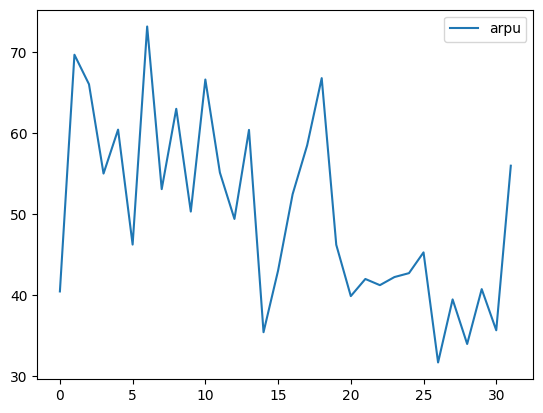

In [8]:
arpu.plot()

In [9]:
arpdau_query = """
-- Query 3: ARPDAU Trend
WITH daily_revenue AS (
  SELECT 
    DATE(event_time) AS date, 
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue
  FROM `casedreamgames.case_db.q1_table_revenue`
  GROUP BY date
),
daily_active AS (
  SELECT 
    DATE(event_time) AS date, 
    COUNT(DISTINCT user_id) AS dau
  FROM `casedreamgames.case_db.q1_table_session`
  GROUP BY date
)
SELECT
  dr.date,
  dr.total_revenue / da.dau AS arpdau
FROM daily_revenue dr
JOIN daily_active da ON dr.date = da.date
ORDER BY dr.date;
"""
arpdau = client.query(arpdau_query).result().to_dataframe()
print("ARPDAU Trend:")
print(arpdau)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


ARPDAU Trend:
          date    arpdau
0   2021-04-30  0.009217
1   2021-05-01  0.031690
2   2021-05-02  0.097424
3   2021-05-03  0.118246
4   2021-05-04  0.163180
5   2021-05-05  0.113050
6   2021-05-06  0.128801
7   2021-05-07  0.164788
8   2021-05-08  0.162895
9   2021-05-09  0.180267
10  2021-05-10  0.125096
11  2021-05-11  0.172869
12  2021-05-12  0.148015
13  2021-05-13  0.176769
14  2021-05-14  0.223543
15  2021-05-15  0.225348
16  2021-05-16  0.201888
17  2021-05-17  0.152005
18  2021-05-18  0.159854
19  2021-05-19  0.179433
20  2021-05-20  0.190565
21  2021-05-21  0.196115
22  2021-05-22  0.180208
23  2021-05-23  0.192616
24  2021-05-24  0.154376
25  2021-05-25  0.135068
26  2021-05-26  0.137664
27  2021-05-27  0.140534
28  2021-05-28  0.173877
29  2021-05-29  0.173344
30  2021-05-30  0.178246
31  2021-05-31  0.155367
32  2021-06-01  0.184357
33  2021-06-02  0.175744
34  2021-06-03  0.186426
35  2021-06-04  0.200359
36  2021-06-05  0.224710
37  2021-06-06  0.220824
38  2021-06

In [11]:
arpdau.arpdau.describe()

count    46.000000
mean      0.164149
std       0.043165
min       0.009217
25%       0.149012
50%       0.171587
75%       0.189530
max       0.225348
Name: arpdau, dtype: float64

<Axes: title={'center': 'ARPDAU'}>

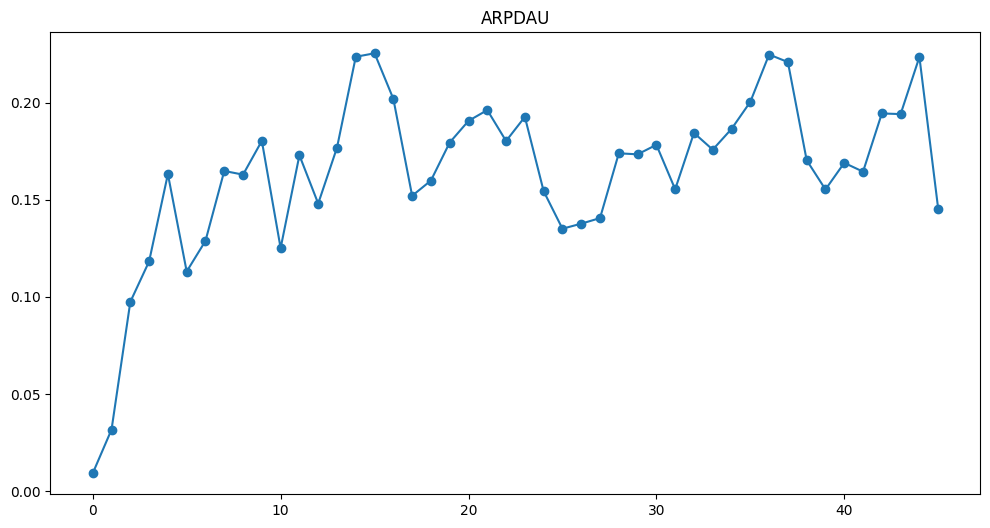

In [12]:
arpdau.arpdau.plot(title='ARPDAU', figsize=(12, 6),style='o-')

In [13]:
retention_query = """
-- Query 4: Next Day Retention Trend 
WITH installs AS (
  SELECT 
    user_id,
    DATE(event_time) AS install_date
  FROM `casedreamgames.case_db.q1_table_install`
),
next_day_sessions AS (
  SELECT 
    user_id,
    DATE(event_time) AS session_date
  FROM `casedreamgames.case_db.q1_table_session`
)
SELECT
  i.install_date,
  COUNT(DISTINCT i.user_id) AS installs,
  COUNT(DISTINCT n.user_id) AS retained_users,
  COUNT(DISTINCT n.user_id) / COUNT(DISTINCT i.user_id) AS retention_rate
FROM installs i
LEFT JOIN next_day_sessions n
  ON i.user_id = n.user_id 
  AND n.session_date = DATE_ADD(i.install_date, INTERVAL 1 DAY)
GROUP BY i.install_date
ORDER BY i.install_date;
"""
retention = client.query(retention_query).result().to_dataframe()
print(retention)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   install_date  installs  retained_users  retention_rate
0    2021-04-30      1064             716        0.672932
1    2021-05-01      9177            5269        0.574153
2    2021-05-02      8803            4902        0.556856
3    2021-05-03      6127            3226        0.526522
4    2021-05-04      6467            3641        0.563012
5    2021-05-05      6747            3576        0.530013
6    2021-05-06      5533            3085        0.557564
7    2021-05-07      6033            3312        0.548981
8    2021-05-08      7177            4064        0.566253
9    2021-05-09      7577            4144        0.546918
10   2021-05-10      5992            3458        0.577103
11   2021-05-11      6121            3464        0.565921
12   2021-05-12      5915            3258        0.550803
13   2021-05-13      5577            3006        0.538999
14   2021-05-14      5199            2761        0.531064
15   2021-05-15      6118            3435        0.561458
16   2021-05-1

<Axes: title={'center': 'Next Day Retention Rate'}>

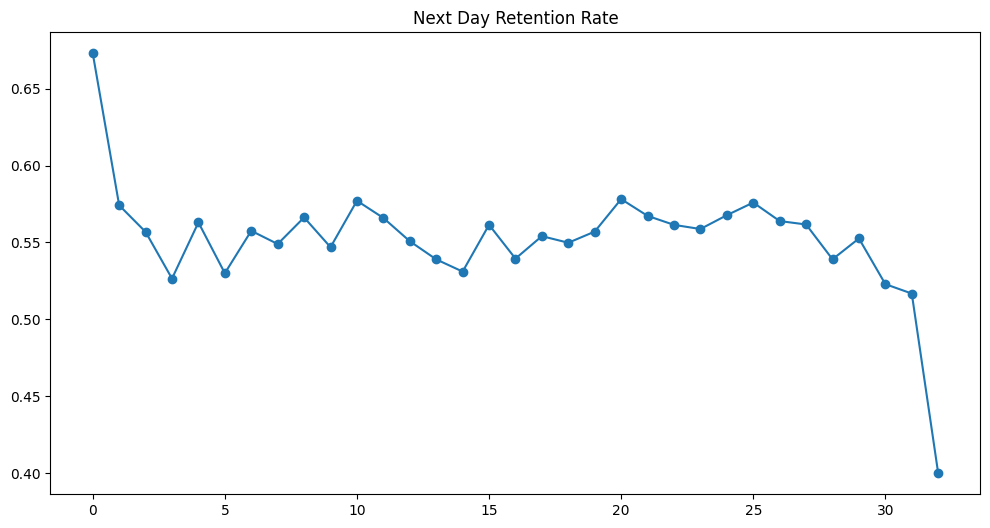

In [15]:
retention.retention_rate.plot(title='Next Day Retention Rate', figsize=(12, 6),style='o-')

In [17]:
roas_query = """
-- Query 5: Daily ROAS Trend
WITH daily_revenue AS (
  SELECT 
    DATE(event_time) AS date, 
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue
  FROM `casedreamgames.case_db.q1_table_revenue`
  GROUP BY date
),
daily_cost AS (
  SELECT 
    date, 
    SUM(cost) AS total_cost
  FROM `casedreamgames.case_db.q1_table_cost`
  GROUP BY date
)
SELECT
  r.date,
  r.total_revenue,
  c.total_cost,
  r.total_revenue / c.total_cost AS roas
FROM daily_revenue r
JOIN daily_cost c ON r.date = c.date
ORDER BY r.date;
"""
roas = client.query(roas_query).result().to_dataframe()
print("Daily ROAS Trend:")
print(roas)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Daily ROAS Trend:
          date  total_revenue  total_cost      roas
0   2021-05-01          313.0     43909.0  0.007128
1   2021-05-02         1418.0     42177.0  0.033620
2   2021-05-03         1871.0     34666.0  0.053972
3   2021-05-04         3003.0     33170.0  0.090534
4   2021-05-05         2449.0     37068.0  0.066068
5   2021-05-06         2855.0     28627.0  0.099731
6   2021-05-07         4108.0     30395.0  0.135154
7   2021-05-08         4664.0     35593.0  0.131037
8   2021-05-09         5799.0     35922.0  0.161433
9   2021-05-10         4063.0     30915.0  0.131425
10  2021-05-11         6020.0     30423.0  0.197877
11  2021-05-12         5469.0     30067.0  0.181894
12  2021-05-13         6769.0     27488.0  0.246253
13  2021-05-14         8876.0     25610.0  0.346583
14  2021-05-15         9587.0     28724.0  0.333763
15  2021-05-16         9131.0     30669.0  0.297727
16  2021-05-17         6858.0     24137.0  0.284128
17  2021-05-18         7380.0     24581.0  0.3

<Axes: title={'center': 'Daily ROAS Trend'}>

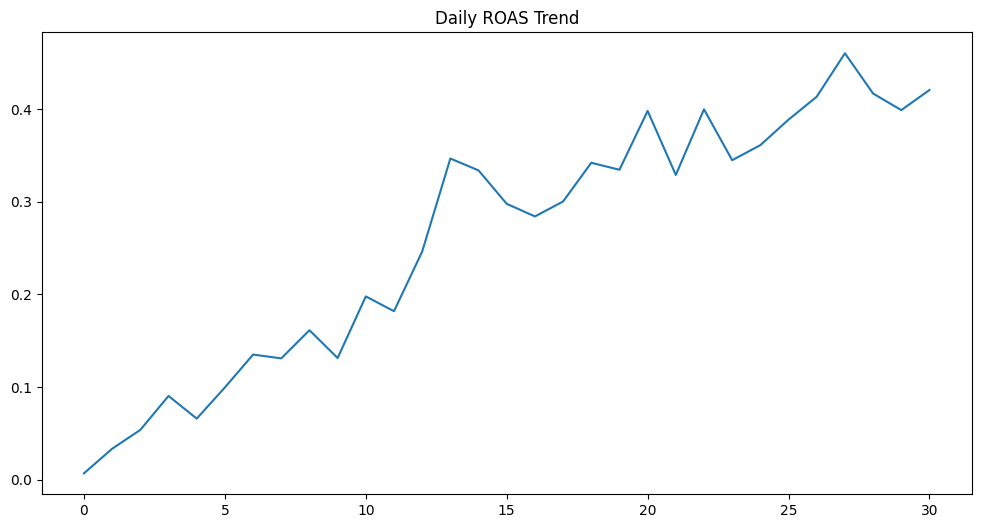

In [18]:
roas.roas.plot(title='Daily ROAS Trend', figsize=(12, 6))

In [19]:
arpdau_by_package_type_query = """
-- Query: ARPDAU by Package Type
WITH daily_package_revenue AS (
  SELECT
    package_type,
    DATE(event_time) AS date,
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue,
    COUNT(DISTINCT user_id) AS purchasing_users
  FROM `casedreamgames.case_db.q1_table_revenue`
  GROUP BY package_type, date
)
SELECT
  package_type,
  date,
  total_revenue / purchasing_users AS arpdau
FROM daily_package_revenue
ORDER BY package_type, date;
"""
arpdau_by_package_type = client.query(arpdau_by_package_type_query).result().to_dataframe()
print("ARPDAU by Package Type:")
print(arpdau_by_package_type)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


ARPDAU by Package Type:
      package_type        date     arpdau
0    awesome_packs  2021-05-01   4.529412
1    awesome_packs  2021-05-02  10.117647
2    awesome_packs  2021-05-03   8.934426
3    awesome_packs  2021-05-04   9.860215
4    awesome_packs  2021-05-05   6.066667
..             ...         ...        ...
111   pretty_packs  2021-06-07   8.982143
112   pretty_packs  2021-06-11   5.574230
113   pretty_packs  2021-06-12   8.087302
114   pretty_packs  2021-06-13   9.344660
115   pretty_packs  2021-06-14  13.763636

[116 rows x 3 columns]


In [22]:
arpdau_by_package_type.groupby('package_type').arpdau.count()

package_type
awesome_packs    45
cool_packs        1
lovely_packs     46
pretty_packs     24
Name: arpdau, dtype: int64

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


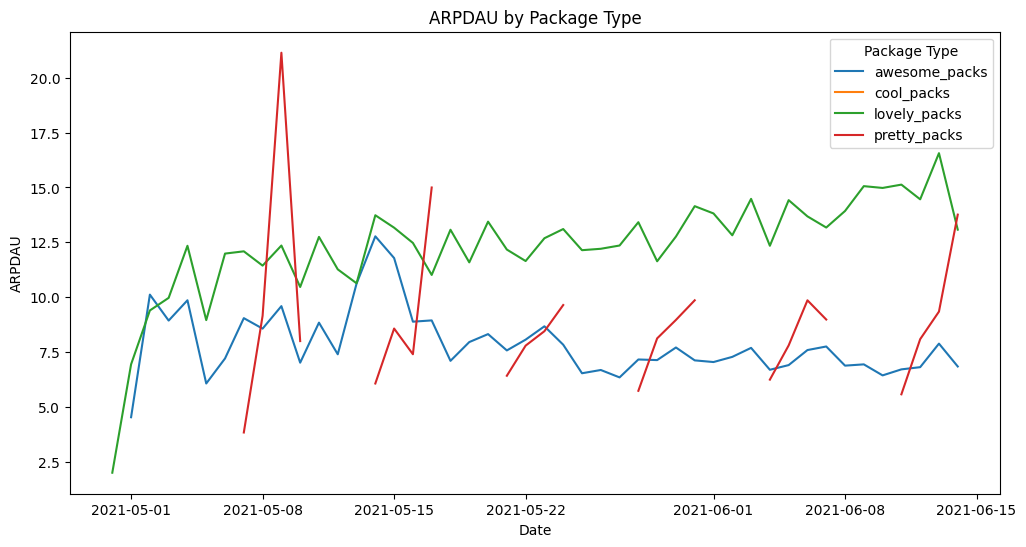

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


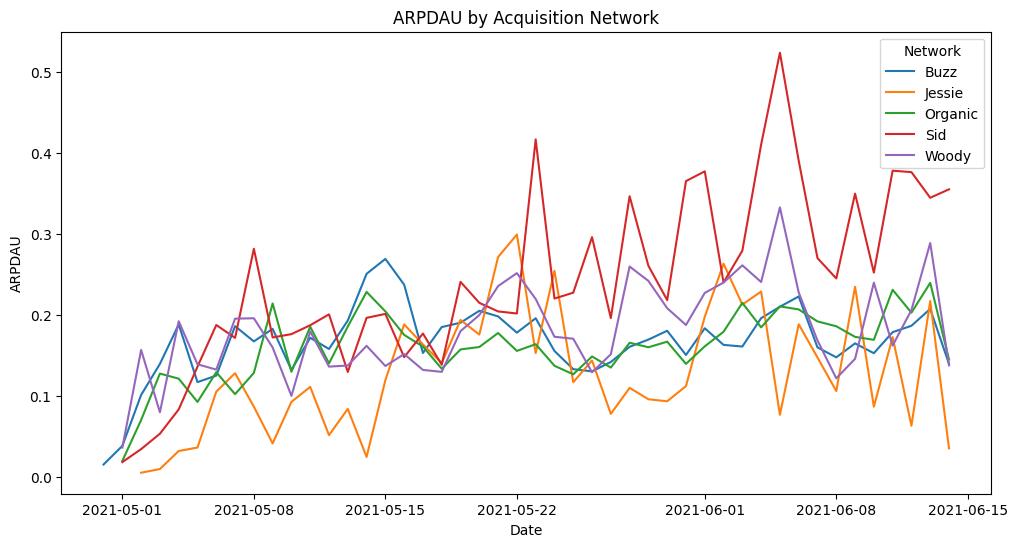

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


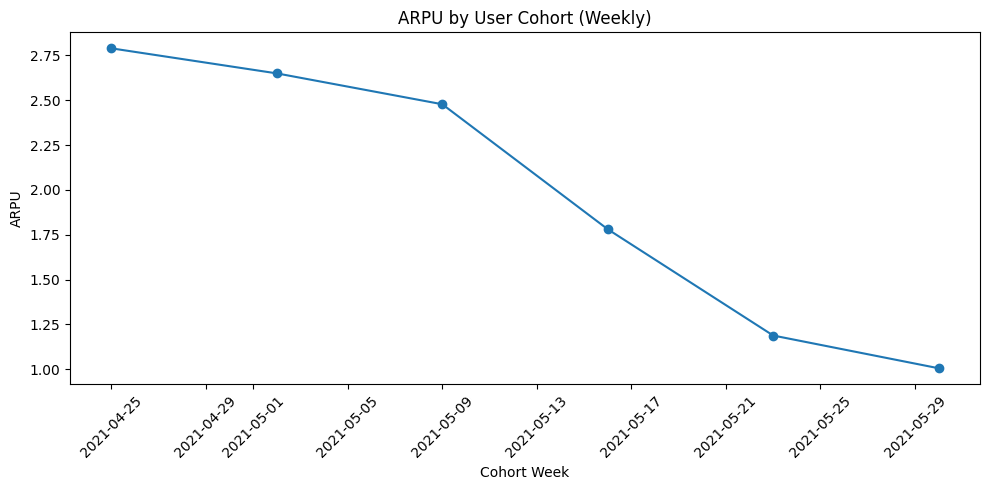

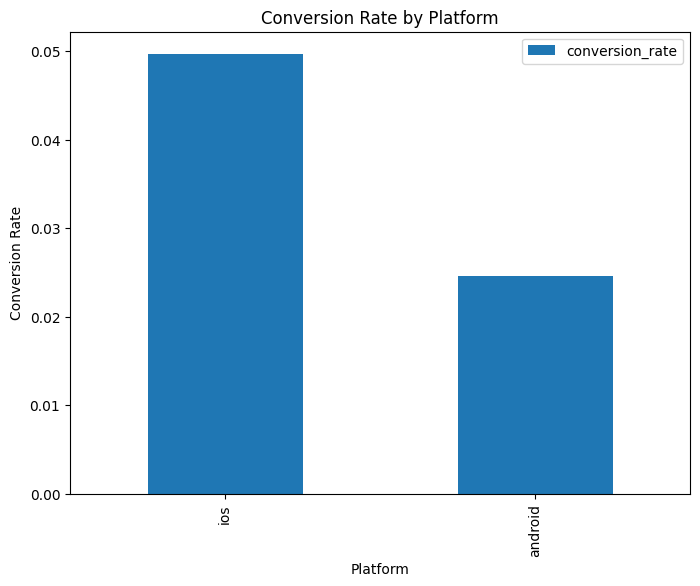

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


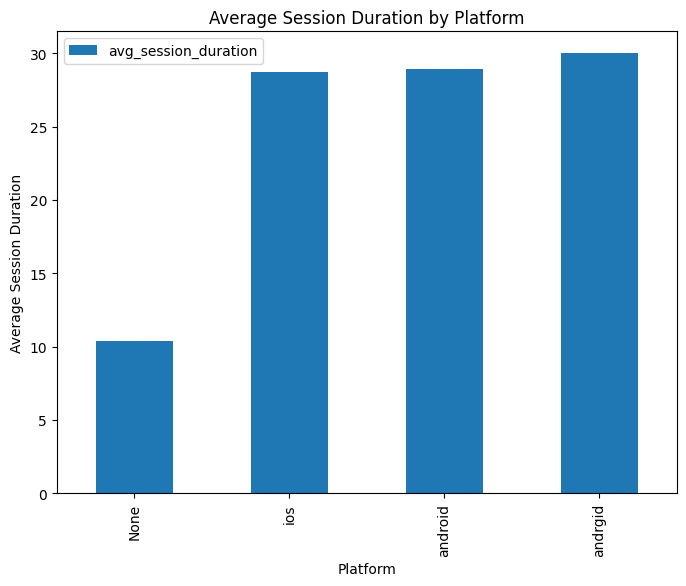

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. ARPDAU by Package Type
arpdau_by_package_type_query = """
-- Query: ARPDAU by Package Type
WITH daily_package_revenue AS (
  SELECT
    package_type,
    DATE(event_time) AS date,
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue,
    COUNT(DISTINCT user_id) AS purchasing_users
  FROM `casedreamgames.case_db.q1_table_revenue`
  GROUP BY package_type, date
)
SELECT
  package_type,
  date,
  total_revenue / purchasing_users AS arpdau
FROM daily_package_revenue
ORDER BY package_type, date;
"""
arpdau_by_package_type = client.query(arpdau_by_package_type_query).result().to_dataframe()
# Pivot for line plot: rows = date, columns = package_type, values = arpdau
df_arpdau_pkg = arpdau_by_package_type.pivot(index='date', columns='package_type', values='arpdau')
df_arpdau_pkg.plot(figsize=(12,6))
plt.title("ARPDAU by Package Type")
plt.xlabel("Date")
plt.ylabel("ARPDAU")
plt.legend(title="Package Type")
plt.show()

# 2. ARPDAU Network Based
arpdau_network_query = """
-- Query: ARPDAU Network Based
WITH revenue_network AS (
  SELECT
    i.network,
    DATE(r.event_time) AS date,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM `casedreamgames.case_db.q1_table_revenue` r
  JOIN `casedreamgames.case_db.q1_table_install` i ON r.user_id = i.user_id
  GROUP BY i.network, date
),
dau_network AS (
  SELECT
    i.network,
    DATE(s.event_time) AS date,
    COUNT(DISTINCT s.user_id) AS dau
  FROM `casedreamgames.case_db.q1_table_session` s
  JOIN `casedreamgames.case_db.q1_table_install` i ON s.user_id = i.user_id
  GROUP BY i.network, date
)
SELECT
  r.network,
  r.date,
  r.total_revenue / d.dau AS arpdau
FROM revenue_network r
JOIN dau_network d ON r.network = d.network AND r.date = d.date
ORDER BY r.network, r.date;
"""
arpdau_network = client.query(arpdau_network_query).result().to_dataframe()
# Pivot for line plot: rows = date, columns = network, values = arpdau
df_arpdau_net = arpdau_network.pivot(index='date', columns='network', values='arpdau')
df_arpdau_net.plot(figsize=(12,6))
plt.title("ARPDAU by Acquisition Network")
plt.xlabel("Date")
plt.ylabel("ARPDAU")
plt.legend(title="Network")
plt.show()

# 3. ARPU by User Cohort
arpu_by_user_cohort_query = """
-- Query: ARPU by User Cohort
WITH cohort AS (
  SELECT
    user_id,
    DATE_TRUNC(DATE(event_time), WEEK) AS cohort_week
  FROM `casedreamgames.case_db.q1_table_install`
),
cohort_revenue AS (
  SELECT
    c.cohort_week,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue,
    COUNT(DISTINCT c.user_id) AS users
  FROM cohort c
  LEFT JOIN `casedreamgames.case_db.q1_table_revenue` r ON c.user_id = r.user_id
  GROUP BY c.cohort_week
)
SELECT
  cohort_week,
  total_revenue / users AS arpu
FROM cohort_revenue
ORDER BY cohort_week;
"""
arpu_by_user_cohort = client.query(arpu_by_user_cohort_query).result().to_dataframe()
plt.figure(figsize=(10,5))
plt.plot(arpu_by_user_cohort['cohort_week'], arpu_by_user_cohort['arpu'], marker='o')
plt.title("ARPU by User Cohort (Weekly)")
plt.xlabel("Cohort Week")
plt.ylabel("ARPU")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Conversion Rate by Groups (Platform)
conversion_rate_query = """
-- Query: Conversion Rate by Groups (Platform)
WITH installs AS (
  SELECT
    user_id,
    platform
  FROM `casedreamgames.case_db.q1_table_install`
),
conversions AS (
  SELECT DISTINCT user_id
  FROM `casedreamgames.case_db.q1_table_revenue`
)
SELECT
  i.platform,
  COUNT(DISTINCT i.user_id) AS installs,
  COUNT(DISTINCT c.user_id) AS converters,
  COUNT(DISTINCT c.user_id) / COUNT(DISTINCT i.user_id) AS conversion_rate
FROM installs i
LEFT JOIN conversions c ON i.user_id = c.user_id
GROUP BY i.platform;
"""
conversion_rate_by_groups = client.query(conversion_rate_query).result().to_dataframe()
conversion_rate_by_groups.set_index('platform', inplace=True)
conversion_rate_by_groups[['conversion_rate']].plot(kind='bar', figsize=(8,6))
plt.title("Conversion Rate by Platform")
plt.xlabel("Platform")
plt.ylabel("Conversion Rate")
plt.show()

# 5. Average Session Duration by Groups (Platform)
avg_session_duration_query = """
-- Query: Average Session Duration by Groups (Platform)
SELECT
  platform,
  AVG(time_spent) AS avg_session_duration
FROM `casedreamgames.case_db.q1_table_session`
GROUP BY platform;
"""
avg_session_duration = client.query(avg_session_duration_query).result().to_dataframe()
avg_session_duration.set_index('platform', inplace=True)
avg_session_duration.plot(kind='bar', y='avg_session_duration', figsize=(8,6))
plt.title("Average Session Duration by Platform")
plt.xlabel("Platform")
plt.ylabel("Average Session Duration")
plt.show()
